# Ensemble modeling approach

In this exercise, we will try to ensemble predictions from the best models we trained in our first approach and will try to train a second tier model.

## Logistic Regression

In [14]:
import pickle
from sklearn.metrics import roc_auc_score

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced_trans_pl2.pkl","rb") as f:
    X_train_balanced_trans_pl2 = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 

In [8]:
# Let's use C = 3.0589 to re-train the classifier and prepare another submission
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

logbal = LogisticRegression(verbose=10, n_jobs=3, C= 3.0589,penalty= "l1")

logbal.fit(X_train_balanced_trans_pl2, y_train_balanced)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation sets
# Load validation sets previously prepared


# Features:
with open("X_val1_trans_pl2.pkl","rb") as f:
    X_val1_trans_pl2 = pickle.load(f)
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
    
# Target labels:    
with open("y_val1.pkl","rb") as f:
    y_val1= pickle.load(f)
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 1
probs = logbal.predict_proba(X_val1_trans_pl2)
probs = probs[:,1]
print("Val1 ROC score: " +str(roc_auc_score(y_val1,probs)))
       
# calculate out-of-the-box roc_score using validation set 2
probs = logbal.predict_proba(X_val2_trans_pl2)
probs = probs[:,1]
print("Val2 ROC score: " +str(roc_auc_score(y_val2,probs))) 


# Save the final classifier
with open((diskname + str("log_final.pkl")), "wb") as f:
    pickle.dump(logbal,f)
    
print("Saved final logistic regression classifier.")    

/Users/OZANAYGUN/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(self.n_jobs))


[LibLinear]Trained model, it took: 1430.3166666666666 minutes.
Val1 ROC score: 0.952874287995
Val2 ROC score: 0.951511484007
Saved final logistic regression classifier.


## Support Vector Machines

In [9]:
import datetime
start = datetime.datetime.now()

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
# Note that we can't get probabilities directly from this LinearSVC function
# We need to wrap into Calibrated Classifier 
# (see: https://stackoverflow.com/questions/35212213/sklearn-how-to-get-decision-probabilities-for-linearsvc-classifier)

lsvcbal = LinearSVC(verbose=10, C = 0.0564)

cal_lsvcbal = CalibratedClassifierCV(base_estimator = lsvcbal,
                                  cv = 3, # Also performs cross-validation
                                  method= "sigmoid") # We use sigmoid function to get probabilities

cal_lsvcbal.fit(X_train_balanced_trans_pl2,y_train_balanced)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")


# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 1
probs = cal_lsvcbal.predict_proba(X_val1_trans_pl2)
probs = probs[:,1]
print("Val1 ROC score: " +str(roc_auc_score(y_val1,probs)))
       
# calculate out-of-the-box roc_score using validation set 2
probs = cal_lsvcbal.predict_proba(X_val2_trans_pl2)
probs = probs[:,1]
print("Val2 ROC score: " +str(roc_auc_score(y_val2,probs)))


# Save the final classifier
with open((diskname + str("svm_final.pkl")), "wb") as f:
    pickle.dump(cal_lsvcbal,f)
    
print("Saved final SVM regression classifier.") 

[LibLinear][LibLinear][LibLinear]It took: 0.4 minutes.
Val1 ROC score: 0.952513357043
Val2 ROC score: 0.952253716778
Saved final SVM regression classifier.


## Random Forest Classifier

In [19]:
#let's try to get a small random sample from the class-balanced set to train the RF algorithm
import numpy as np
import random
random.seed(112)
rows = random.sample(list(range(0,X_train_balanced_trans_pl2.shape[0])),50000)
X_train_balanced_trans_pl2_sample = X_train_balanced_trans_pl2[rows,]
y_train_balanced_sample = y_train_balanced.iloc[rows]

print("Sampled a smaller training set.")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

rf = RandomForestClassifier(n_estimators=1320,
                            min_samples_leaf= 2,
                            min_samples_split= 9,
                            max_features= 306,
                            max_depth= 297,n_jobs=3)

rf.fit(X_train_balanced_trans_pl2_sample, y_train_balanced_sample)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation sets
# Load validation sets previously prepared


# Features:
with open("X_val1_trans_pl2.pkl","rb") as f:
    X_val1_trans_pl2 = pickle.load(f)
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
    
# Target labels:    
with open("y_val1.pkl","rb") as f:
    y_val1= pickle.load(f)
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 1
probs = rf.predict_proba(X_val1_trans_pl2)
probs = probs[:,1]
print("Val1 ROC score: " +str(roc_auc_score(y_val1,probs)))
       
# calculate out-of-the-box roc_score using validation set 2
probs = rf.predict_proba(X_val2_trans_pl2)
probs = probs[:,1]
print("Val2 ROC score: " +str(roc_auc_score(y_val2,probs))) 


# Save the final classifier
with open((diskname + str("rf_final.pkl")), "wb") as f:
    pickle.dump(rf,f)
    
print("Saved final random forest  classifier.")


Sampled a smaller training set.
Trained model, it took: 1436.2166666666667 minutes.
Val1 ROC score: 0.947543785832
Val2 ROC score: 0.945366327648
Saved final random forest  classifier.


## Adaboost classifier

In [36]:
from sklearn.ensemble import AdaBoostClassifier

In [53]:
#let's try to get a small random sample from the class-balanced set to train the RF algorithm
import numpy as np
import random
random.seed(112)
rows = random.sample(list(range(0,X_train_balanced_trans_pl2.shape[0])),100000)
X_train_balanced_trans_pl2_sample = X_train_balanced_trans_pl2[rows,]
y_train_balanced_sample = y_train_balanced.iloc[rows]

print("Sampled a smaller training set.")

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ab = AdaBoostClassifier(n_estimators=600, learning_rate= 0.2)

ab.fit(X_train_balanced_trans_pl2_sample, y_train_balanced_sample)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation sets
# Load validation sets previously prepared


# Features:
with open("X_val1_trans_pl2.pkl","rb") as f:
    X_val1_trans_pl2 = pickle.load(f)
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
    
# Target labels:    
with open("y_val1.pkl","rb") as f:
    y_val1= pickle.load(f)
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 1
probs = ab.predict_proba(X_val1_trans_pl2)
probs = probs[:,1]
print("Val1 ROC score: " +str(roc_auc_score(y_val1,probs)))
       
# calculate out-of-the-box roc_score using validation set 2
probs = ab.predict_proba(X_val2_trans_pl2)
probs = probs[:,1]
print("Val2 ROC score: " +str(roc_auc_score(y_val2,probs))) 


# Save the final classifier
with open((diskname + str("ab_final.pkl")), "wb") as f:
    pickle.dump(ab,f)
    
print("Saved ada boost  classifier.")



Sampled a smaller training set.
Trained model, it took: 1435.4333333333334 minutes.
Val1 ROC score: 0.945943193181
Val2 ROC score: 0.946552900812
Saved ada boost  classifier.


## Building the ensemble classifier

We will use X_val1 predictions from the two of our best models to train a new classifier against the y_val1. We will try to optimize the performance of this new classifier using X_val2 and y_val2.

In [1]:
import pickle
# Features:
with open("X_val1_trans_pl2.pkl","rb") as f:
    X_val1_trans_pl2 = pickle.load(f)
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
    
# Target labels:    
with open("y_val1.pkl","rb") as f:
    y_val1= pickle.load(f)
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)

In [54]:
# Write a function that return secondary features
diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

def secondary_features(X_train):
    import pandas as pd
    # Load established classifiers
    with open((diskname + str("log_final.pkl")), "rb") as f:
        clf1 = pickle.load(f)
    with open((diskname + str("svm_final.pkl")), "rb") as f:
        clf2 = pickle.load(f)
    with open((diskname + str("ab_final.pkl")), "rb") as f:
        clf3 = pickle.load(f)    
    print("Loaded classifiers.")    
    # Collect prediction probabilities as new features    
    sec_features = pd.DataFrame()
    sec_features["f1"] = clf1.predict_proba(X_train)[:,1]
    sec_features["f2"] = clf2.predict_proba(X_train)[:,1]
    sec_features["f3"] = clf3.predict_proba(X_train)[:,1]
    print("Collected features.")
    
    # Return new features as array
    return sec_features.values



In [55]:
import datetime
# it takes about 7 mins to transform
start = datetime.datetime.now()
X_train_ensemble = secondary_features(X_val1_trans_pl2)

end = datetime.datetime.now()
process_time = start - end
print("Transformed into secondary features, it took: " + str((process_time.seconds)/60) + " minutes.")


Loaded classifiers.
Collected features.
Transformed into secondary features, it took: 1438.15 minutes.


In [56]:
X_train_ensemble


array([[ 0.4198908 ,  0.36075446,  0.49962477],
       [ 0.02056251,  0.04736733,  0.49493243],
       [ 0.11612122,  0.11748793,  0.49707586],
       ..., 
       [ 0.39121193,  0.34091477,  0.50093734],
       [ 0.04425574,  0.05957478,  0.49552605],
       [ 0.59588697,  0.60118489,  0.50197116]])

### Ensemble Logisticregression classifier

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = LogisticRegression(verbose=10)
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

[LibLinear]Trained ensemble model, it took: 1439.9666666666667 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.952225786469


### Ensemble SVM classifier

In [10]:
from sklearn.svm import LinearSVC  
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
import datetime

start = datetime.datetime.now()

lsvcbal = LinearSVC(verbose=10, C= 5)

ensb = CalibratedClassifierCV(base_estimator = lsvcbal,
                                  cv = 3, # Also performs cross-validation
                                  method= "sigmoid") # We use sigmoid function to get probabilities
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

[LibLinear][LibLinear][LibLinear]Trained ensemble model, it took: 1439.1 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.950172219726


### Ensemble Random Forest classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = RandomForestClassifier()
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

Trained ensemble model, it took: 1439.1166666666666 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.815179565761


### Ensemble Extratree Classifier

In [58]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = ExtraTreesClassifier()
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

Trained ensemble model, it took: 1439.8833333333334 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.827961862994


### Ensemble Naive Bayes classifier

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = MultinomialNB()
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

Trained ensemble model, it took: 1439.9833333333333 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.557963136275


### Ensemble XGboost classifier

In [59]:
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = xgb.XGBClassifier()
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))


Trained ensemble model, it took: 1439.1166666666666 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.951161891619


### Ensemble QDA classifier

In [60]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = QuadraticDiscriminantAnalysis(reg_param= 0.005)
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

Trained ensemble model, it took: 1439.9833333333333 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.95241337647


In [61]:
# Hyperparameter optimization
# We start by defining the score we want to be maximized using Bayesian Optimization
# Return validated 'roc_auc' score from Classifier
# Note that the parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def maximizer(reg_param,p1,p2):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    estimator_function = QuadraticDiscriminantAnalysis(reg_param= reg_param, priors = [p1,p2])
    
    # Fit the estimator
    estimator_function.fit(X_train_ensemble, y_val1)
        
    # calculate out-of-the-box roc_score using validation set 2
    probs = estimator_function.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
    val2_roc = roc_auc_score(y_val2,probs)
    
    # return the validation score to be maximized 
    return val2_roc

import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.

hyperparameter_space = {
        'reg_param': (0.004,0.005),
        "p1": (0.8,0.999),
        "p2": (0.01,0.2)
}

BO = BayesianOptimization(f = maximizer, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments

BO.maximize(init_points=10,n_iter=10,acq='ucb', kappa= 5, **gp_params)


Initialization
-------------------------------------------------------------------
 Step |   Time |      Value |        p1 |        p2 |   reg_param | 
Loaded classifiers.


KeyboardInterrupt: 

In [78]:
# Prepare an ensemble prediction using QDA classifier
# Train with tuned parameter
ensb = QuadraticDiscriminantAnalysis(reg_param= 0.0041)
ensb.fit(X_train_ensemble, y_val1)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0041,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [81]:
# Prepare a submission using the tuned QDA classifier

import pandas as pd
click_id = pd.read_hdf("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/click_id.h5")
def prepare_submission(predictions,filename = "new_submission", click_id = click_id):
    """predictions: a list containing the predicted probabilities in the test set. """
    is_attributed = pd.Series(predictions)
    submission_frame = pd.DataFrame()
    submission_frame["click_id"] = click_id
    submission_frame["is_attributed"] = is_attributed.apply(lambda x: format(x,".9f"))  # Reformat the probabilities upto the 9th decimal point
    filename = filename + ".csv"
    submission_frame.to_csv(filename,index = False)
    print("File saved as :" + filename)


# let's perform a prediction using the test set
# Load the sparse matrix 
import scipy.sparse as sp
test_proc_p12 = sp.load_npz("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/test_proc_pl2.npz").tocsr()
print("Loaded processed test sparse matrix.")

Loaded processed test sparse matrix.


In [82]:
probs = ensb.predict_proba(secondary_features(test_proc_p12))[:,1]
print("Prepared QDA ensemble probs.")
# Prepare the submission file
prepare_submission(predictions= probs, 
                   filename= "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/ENSB_QDA_submission") 

Loaded classifiers.
Collected features.
Prepared QDA ensemble probs.
File saved as :/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/ENSB_QDA_submission.csv


This submission scored 0.9605.

### Ensemble KNN classifier

In [6]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = KNeighborsClassifier(n_neighbors= 150)
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

Trained ensemble model, it took: 1439.95 minutes.
Loaded classifiers.
Collected features.


KeyboardInterrupt: 

### Ensemble LDA classifier

In [13]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = LinearDiscriminantAnalysis(shrinkage= 'auto', solver= 'lsqr')
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

Trained ensemble model, it took: 1439.9833333333333 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.952363803875


### Ensemble Gaussian Naive Bayes Classifier

In [62]:
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = GaussianNB(priors = [0.999999,0.000001])
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))

Trained ensemble model, it took: 1439.9833333333333 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.950236607507


### Ensemble MLPClassifier

In [20]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import datetime

start = datetime.datetime.now()

ensb = MLPClassifier(alpha = 0.1, hidden_layer_sizes=(10,10,10,))
ensb.fit(X_train_ensemble, y_val1)

end2 = datetime.datetime.now()
process_time = start - end2
print("Trained ensemble model, it took: " + str((process_time.seconds)/60) + " minutes.")

start = datetime.datetime.now()

diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)
    
# Make predictions and calculate average valdation roc score 
# calculate out-of-the-box roc_score using validation set 2
# Note that we are converting features to secondary features since we are using ensemble model

probs = ensb.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
print("Ensemble Val ROC score: " +str(roc_auc_score(y_val2,probs)))


Trained ensemble model, it took: 1439.5666666666666 minutes.
Loaded classifiers.
Collected features.
Ensemble Val ROC score: 0.95230705822


In [14]:
ensb.get_params


<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.5,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)>

In [18]:
# Hyperparameter optimization
# We start by defining the score we want to be maximized using Bayesian Optimization
# Return validated 'roc_auc' score from Classifier
# Note that the parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def maximizer(alpha,N1,N2,N3):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    estimator_function = MLPClassifier(alpha = alpha,
                                       hidden_layer_sizes=(int(N1),int(N2),int(N3),),
                                       verbose = True, warm_start = True)
                                       
    
    # Fit the estimator
    estimator_function.fit(X_train_ensemble, y_val1)
        
    # calculate out-of-the-box roc_score using validation set 2
    probs = estimator_function.predict_proba(secondary_features(X_val2_trans_pl2))[:,1]
    val2_roc = roc_auc_score(y_val2,probs)
    
    # return the validation score to be maximized 
    return val2_roc

import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.

hyperparameter_space = {
        'alpha': (0.00001,1),
        'N1': (10,200),
        'N2': (10,200),
        'N3': (10,200)
}

BO = BayesianOptimization(f = maximizer, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments

BO.maximize(init_points=100,n_iter=100,acq='ucb', kappa= 5, **gp_params)

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |        N1 |        N2 |        N3 |     alpha | 
Iteration 1, loss = 0.02328634
Iteration 2, loss = 0.01417183
Iteration 3, loss = 0.01323872
Iteration 4, loss = 0.01295399
Iteration 5, loss = 0.01282552
Iteration 6, loss = 0.01278816
Iteration 7, loss = 0.01274812
Iteration 8, loss = 0.01273363
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded classifiers.
Collected features.
    1 | 04m06s |    0.50000 |  138.1691 |  146.4545 |  163.6315 |    0.3751 | 
Iteration 1, loss = 0.02400890
Iteration 2, loss = 0.01370346
Iteration 3, loss = 0.01319368
Iteration 4, loss = 0.01297327
Iteration 5, loss = 0.01287496
Iteration 6, loss = 0.01281547
Iteration 7, loss = 0.01278381
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded classifiers.
Collected features.
    2 | 01m56s |    0.

Collected features.
   18 | 01m51s |    0.04766 |   39.3856 |   70.8663 |  185.0109 |    0.9558 | 
Iteration 1, loss = 0.02696712
Iteration 2, loss = 0.01435707
Iteration 3, loss = 0.01354445
Iteration 4, loss = 0.01319261
Iteration 5, loss = 0.01300981
Iteration 6, loss = 0.01289042
Iteration 7, loss = 0.01281019
Iteration 8, loss = 0.01276652
Iteration 9, loss = 0.01272297
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded classifiers.
Collected features.
   19 | 03m06s |    0.95212 |  190.6947 |  147.1240 |   34.7259 |    0.8206 | 
Iteration 1, loss = 0.02259393
Iteration 2, loss = 0.01470273
Iteration 3, loss = 0.01462508
Iteration 4, loss = 0.01404491
Iteration 5, loss = 0.01332289
Iteration 6, loss = 0.01305312
Iteration 7, loss = 0.01293119
Iteration 8, loss = 0.01283964
Iteration 9, loss = 0.01278164
Iteration 10, loss = 0.01273478
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded cla

Iteration 7, loss = 0.01279173
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded classifiers.
Collected features.
   37 | 01m04s |    0.04770 |  128.1215 |   14.6908 |  107.9998 |    0.6837 | 
Iteration 1, loss = 0.02865082
Iteration 2, loss = 0.01415810
Iteration 3, loss = 0.01339232
Iteration 4, loss = 0.01309542
Iteration 5, loss = 0.01295149
Iteration 6, loss = 0.01286207
Iteration 7, loss = 0.01279973
Iteration 8, loss = 0.01276512
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded classifiers.
Collected features.
   38 | 01m26s |    0.95231 |   74.0596 |   58.1342 |   82.8534 |    0.7220 | 
Iteration 1, loss = 0.01768165
Iteration 2, loss = 0.01241947
Iteration 3, loss = 0.01236736
Iteration 4, loss = 0.01236734
Iteration 5, loss = 0.01234383
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded classifiers.
Collected features.
   39 | 02m12s 

Iteration 5, loss = 0.00895295
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded classifiers.
Collected features.
   56 | 10m29s |    0.95231 |  125.7681 |  177.4500 |  123.0401 |    0.0614 | 
Iteration 1, loss = 0.02826262
Iteration 2, loss = 0.01393317
Iteration 3, loss = 0.01326702
Iteration 4, loss = 0.01301034
Iteration 5, loss = 0.01289063
Iteration 6, loss = 0.01284299
Iteration 7, loss = 0.01279609
Iteration 8, loss = 0.01275392
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Loaded classifiers.
Collected features.
   57 | 02m59s |    0.95231 |  157.9416 |  120.3326 |  111.7916 |    0.9003 | 
Iteration 1, loss = 0.03073818
Iteration 2, loss = 0.01420939
Loaded classifiers.
Collected features.


KeyboardInterrupt: 

In [21]:
# Prepare a submission using the tuned MLPC classifier

import pandas as pd
click_id = pd.read_hdf("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/click_id.h5")
def prepare_submission(predictions,filename = "new_submission", click_id = click_id):
    """predictions: a list containing the predicted probabilities in the test set. """
    is_attributed = pd.Series(predictions)
    submission_frame = pd.DataFrame()
    submission_frame["click_id"] = click_id
    submission_frame["is_attributed"] = is_attributed.apply(lambda x: format(x,".9f"))  # Reformat the probabilities upto the 9th decimal point
    filename = filename + ".csv"
    submission_frame.to_csv(filename,index = False)
    print("File saved as :" + filename)


# let's perform a prediction using the test set
# Load the sparse matrix 
import scipy.sparse as sp
test_proc_p12 = sp.load_npz("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/test_proc_pl2.npz").tocsr()
print("Loaded processed test sparse matrix.")

probs = ensb.predict_proba(secondary_features(test_proc_p12))[:,1]
print("Prepared MLPC ensemble probs.")
# Prepare the submission file
prepare_submission(predictions= probs, 
                   filename= "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/ENSB_MLPC_submission") 



Loaded processed test sparse matrix.
Loaded classifiers.
Collected features.
Prepared MLPC ensemble probs.
File saved as :/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/ENSB_MLPC_submission.csv


###  Ensemble models to train a weight-based meta-model using Bayesian Optimization

In [44]:
diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"

# Test performance using the validation set 2
# Load validation set previously prepared

# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2_trans_pl2 = pickle.load(f) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)

import pandas as pd
# Load established classifiers
with open((diskname + str("log_final.pkl")), "rb") as f:
    clf1 = pickle.load(f)
with open((diskname + str("svm_final.pkl")), "rb") as f:
    clf2 = pickle.load(f)   
print("Loaded classifiers.")    
# Collect prediction probabilities as new features    
f1 = clf1.predict_proba(X_val2_trans_pl2)[:,1]
f2 = clf2.predict_proba(X_val2_trans_pl2)[:,1]
print("Collected features.")

seed = 112 # Random seed

def maximizer(w1):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    w2 = abs(1-w1)
        
    # calculate out-of-the-box roc_score using validation set 2
    probs = (w1 * (np.sqrt(f1) + np.cbrt(f1))) + (w2 * (f2 + f2 **2 + f2 **3)) 
    val2_roc = roc_auc_score(y_val2,probs)
    
    # return the validation score to be maximized 
    return val2_roc

import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.

hyperparameter_space = {
        'w1': (0.1,0.3)
}

BO = BayesianOptimization(f = maximizer, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments

BO.maximize(init_points=10,n_iter=100,acq='ucb', kappa= 20, **gp_params)

Loaded classifiers.
Collected features.
Initialization
-----------------------------------------
 Step |   Time |      Value |        w1 | 
    1 | 00m00s |    0.95257 |    0.1750 | 
    2 | 00m00s |    0.95259 |    0.2281 | 
    3 | 00m00s |    0.95258 |    0.2900 | 
    4 | 00m00s |    0.95250 |    0.1151 | 
    5 | 00m00s |    0.95259 |    0.2554 | 
    6 | 00m00s |    0.95259 |    0.2665 | 
    7 | 00m00s |    0.95249 |    0.1110 | 
    8 | 00m00s |    0.95259 |    0.2635 | 
    9 | 00m00s |    0.95258 |    0.2771 | 
   10 | 00m00s |    0.95260 |    0.2445 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |        w1 | 
   11 | 00m07s |    0.95260 |    0.2359 | 
   12 | 00m05s |    0.95259 |    0.2539 | 
   13 | 00m04s |    0.95257 |    0.1624 | 
   14 | 00m03s |    0.95259 |    0.2151 | 
   15 | 00m06s |    0.95252 |    0.1291 | 
   16 | 00m03s |    0.95260 |    0.2377 | 
   17 | 00m08s |    0.95255 |    0.1510 | 
   18 | 00m05s |    0.

KeyboardInterrupt: 

In [45]:
# Let's submit a prediction we prepared this emprical way
# Load the sparse matrix 
import scipy.sparse as sp
test_proc_p12 = sp.load_npz("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/test_proc_pl2.npz").tocsr()
print("Loaded processed test sparse matrix.")

import pandas as pd
click_id = pd.read_hdf("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/click_id.h5")
def prepare_submission(predictions,filename = "new_submission", click_id = click_id):
    """predictions: a list containing the predicted probabilities in the test set. """
    is_attributed = pd.Series(predictions)
    submission_frame = pd.DataFrame()
    submission_frame["click_id"] = click_id
    submission_frame["is_attributed"] = is_attributed.apply(lambda x: format(x,".9f"))  # Reformat the probabilities upto the 9th decimal point
    filename = filename + ".csv"
    submission_frame.to_csv(filename,index = False)
    print("File saved as :" + filename)

# Collect prediction probabilities as new features    
f1 = clf1.predict_proba(test_proc_p12)[:,1]
f2 = clf2.predict_proba(test_proc_p12)[:,1]
print("Collected features.")




Loaded processed test sparse matrix.
Collected features.


NameError: name 'np' is not defined

In [46]:
import numpy as np
w1 = 0.2445
w2 = abs(1-w1)

probs = (w1 * (np.sqrt(f1) + np.cbrt(f1))) + (w2 * (f2 + f2 **2 + f2 **3)) 
print("Prepared WB ensemble probs.")
# Prepare the submission file
prepare_submission(predictions= probs, 
                   filename= "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/ENSB_WB_submission") 



Prepared WB ensemble probs.
File saved as :/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/ENSB_WB_submission.csv


## Streaming data approach to train a Multinomial Naive Bayes Ensemble Model

In [65]:
# Define a function to stream and process mini-batches of training data
# We will avoid the first 3 million rows from the training set since this includes the validation set 
import pandas as pd
import datetime
import numpy as np
from sklearn.metrics import roc_auc_score

# Label text features
Text_features = ["app","device","os","channel"]

##############################################################
# Define utility function to parse and process text features
##############################################################
# Note we avoid lambda functions since they don't pickle when we want to save the pipeline later   
def column_text_processer_nolambda(df,text_columns = Text_features):
    import pandas as pd
    import numpy as np
    """"A function that will merge/join all text in a given row to make it ready for tokenization. 
    - This function should take care of converting missing values to empty strings. 
    - It should also convert the text to lowercase.
    df= pandas dataframe
    text_columns = names of the text features in df
    """ 
    # Select only non-text columns that are in the df
    text_data = df[text_columns]
    
    # Fill the missing values in text_data using empty strings
    text_data.fillna("",inplace=True)
    
    # Concatenate feature name to each category encoding for each row
    # E.g: encoding 3 at device column will read as device3 to make each encoding unique for a given feature
    for col_index in list(text_data.columns):
        text_data[col_index] = col_index + text_data[col_index].astype(str)
    
    # Join all the strings in a given row to make a vector
    # text_vector = text_data.apply(lambda x: " ".join(x), axis = 1)
    text_vector = []
    for index,rows in text_data.iterrows():
        text_item = " ".join(rows).lower()
        text_vector.append(text_item)

    # return text_vector as pd.Series object to enter the tokenization pipeline
    return pd.Series(text_vector)

#######################################################################
# Define custom processing functions to add the log_total_clicks and 
# log_total_click_time features, and remove the unwanted base features
#######################################################################
def column_time_processer(X_train):
    import pandas as pd
    import numpy as np

    # Convert click_time to datetime64 dtype 
    X_train.click_time = pd.to_datetime(X_train.click_time)

    # Calculate the log_total_clicks for each ip and add as a new feature to temp_data
    temp_data = pd.DataFrame(np.log(X_train.groupby(["ip"]).size()),
                                    columns = ["log_total_clicks"]).reset_index()


    # Calculate the log_total_click_time for each ip and add as a new feature to temp_data
    # First define a function to process selected ip group 
    def get_log_total_click_time(group):
        diff = (max(group.click_time) - min(group.click_time)).seconds
        return np.log(diff+1)

    # Then apply this function to each ip group and extract the total click time per ip group
    log_time_frame = pd.DataFrame(X_train.groupby(["ip"]).apply(get_log_total_click_time),
                                  columns=["log_total_click_time"]).reset_index()

    # Then add this new feature to the temp_data
    temp_data = pd.merge(temp_data,log_time_frame, how = "left",on = "ip")

    # Combine temp_data with X_train to maintain X_train key order
    temp_data = pd.merge(X_train,temp_data,how = "left",on = "ip")

    # Drop features that are not needed
    temp_data = temp_data[["log_total_clicks","log_total_click_time"]]

    # Return only the numeric features as a tensor to integrate into the numeric feature branch of the pipeline
    return temp_data


#############################################################################
# We need to wrap these custom utility functions using FunctionTransformer
from sklearn.preprocessing import FunctionTransformer
# FunctionTransformer wrapper of utility functions to parse text and numeric features
# Note how we avoid putting any arguments into column_text_processer or column_time_processer
#############################################################################
get_numeric_data = FunctionTransformer(func = column_time_processer, validate=False) 
get_text_data = FunctionTransformer(func = column_text_processer_nolambda,validate=False) 

#############################################################################
# Create the token pattern: TOKENS_ALPHANUMERIC
# #Note this regex will match either a whitespace or a punctuation to tokenize 
# the string vector on these preferences, in our case we only have white spaces in our text  
#############################################################################
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Re-load the userclick_pipeline2 to work with
import pickle
with open("userclick_pipeline2.pkl","rb") as f:
    userclick_pipeline2 = pickle.load(f)


# This is just to initially get the column names
training_set = pd.read_csv("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/train.csv",
                           nrows=2,
                           dtype = "str")
column_names = training_set.columns

train_file = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/train.csv"

def stream_training_data(filename,batchsize,skiprows = 3000000):
    import warnings
    warnings.filterwarnings('ignore')
    batch = pd.read_csv(filename,skiprows = skiprows,names = list(column_names),nrows= batchsize,dtype = "str")
    print("Read the new batch.")
    # Seperate features and labels
    X_train = batch.drop(["is_attributed","attributed_time"], axis = 1)
    y_train = pd.to_numeric(batch.is_attributed)
    # Process features using the pipeline
    X_train = userclick_pipeline2.transform(X_train)
    print("Processed the new batch.")
    # Return features and labels ready for training
    return (X_train, y_train)

In [71]:
# Write a function that return secondary features
diskname = "/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/"
import pandas as pd
# Load established classifiers
with open((diskname + str("log_final.pkl")), "rb") as f:
    clf1 = pickle.load(f)
with open((diskname + str("svm_final.pkl")), "rb") as f:
    clf2 = pickle.load(f)
with open((diskname + str("ab_final.pkl")), "rb") as f:
    clf3 = pickle.load(f)    
print("Loaded classifiers.") 
    
def secondary_features(X_train):   
    # Collect prediction probabilities as new features    
    sec_features = pd.DataFrame()
    sec_features["f1"] = clf1.predict_proba(X_train)[:,1]
    sec_features["f2"] = clf2.predict_proba(X_train)[:,1]
    sec_features["f3"] = clf3.predict_proba(X_train)[:,1]
    print(">>> From secondary_features: Collected features.")
    # Return new features as array
    return sec_features.values

# Prepare two validation sets: load and transform them into secondary features
# Features:
with open("X_val1_trans_pl2.pkl","rb") as f:
    X_val1 = secondary_features(pickle.load(f)) 
# labels:    
with open("y_val1.pkl","rb") as f:
    y_val1= pickle.load(f)

print("Loaded and transformed Val 1.")    
    
# Features:
with open("X_val2_trans_pl2.pkl","rb") as f:
    X_val2 = secondary_features(pickle.load(f)) 
# labels:    
with open("y_val2.pkl","rb") as f:
    y_val2= pickle.load(f)

print("Loaded and transformed Val 2.")  


Loaded classifiers.


In [86]:
# Write a main loop to train classifiers and accumulate performance metrics
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB  

# Instantiate classifiers
mnbi = MultinomialNB(alpha = 0.01)
sgdc = SGDClassifier(loss="log")

all_classes = np.array([0, 1])
skiprows = 3000000
batchsize = 10000
mnbi_vscore = []
sgdc_vcsore = []
mnbi_vscore_max = 0
sgdc_vcsore_max = 0

start = datetime.datetime.now()

for i in range(1,10000):
    start_batch = datetime.datetime.now()
    print("Starting a new batch.")
    
    ##################
    # Data Streaming
    ##################
    
    # Stream a small batch of training data to convert into secondary features
    X_train, y_train = stream_training_data(filename= train_file,batchsize= batchsize, skiprows= skiprows)
    print("Streamed new batch of training data.")
    X_train_ensemble = secondary_features(X_train)
    print("Processed new batch of training data.")
    skiprows += batchsize
    
    #######################
    # Training Classifiers
    #######################
    
    # Train mnbi classifier using partial_fit and secondary features
    mnbi.partial_fit(X_train_ensemble, y_train,all_classes)
    print("Trained mnbi classifier.")
    
    # Train sgdc classifier using partial_fit and secondary features
    sgdc.partial_fit(X_train_ensemble, y_train,all_classes)
    print("Trained sgdc classifier.")
    
    ###############################
    # Model validation and Update
    ###############################
    
    
    ###############
    clf = mnbi
    # Make predictions and calculate average valdation roc score 
    # calculate out-of-the-box roc_score using validation set 1
    probs = clf.predict_proba(X_val1)
    probs = probs[:,1]
    val1_roc = roc_auc_score(y_val1,probs)
    
    # calculate out-of-the-box roc_score using validation set 2
    probs = clf.predict_proba(X_val2)
    probs = probs[:,1]
    val2_roc = roc_auc_score(y_val2,probs)
    
    # Accumulate the mean validation score to be maximized 
    mnbi_vscore.append(np.array([val1_roc,val2_roc]).mean())
    print("mnbi completed batch " + str(i) + " with validation score: " + str(np.array([val1_roc,val2_roc]).mean()))
    
    # Save the interim model if validation score has increased
    if np.array([val1_roc,val2_roc]).mean() > mnbi_vscore_max:
        mnbi_vscore_max = np.array([val1_roc,val2_roc]).mean()
        with open((diskname + str("ensmb_mnbi_final.pkl")), "wb") as f:
            pickle.dump(mnbi,f)
        print("**** mnbi_vscore_max exceeded, model updated.****")
    
    ################
    clf = sgdc
    # Make predictions and calculate average valdation roc score 
    # calculate out-of-the-box roc_score using validation set 1
    probs = clf.predict_proba(X_val1)
    probs = probs[:,1]
    val1_roc = roc_auc_score(y_val1,probs)
    
    # calculate out-of-the-box roc_score using validation set 2
    probs = clf.predict_proba(X_val2)
    probs = probs[:,1]
    val2_roc = roc_auc_score(y_val2,probs)
    
    # Accumulate the mean validation score to be maximized 
    sgdc_vcsore.append(np.array([val1_roc,val2_roc]).mean())
    print("sgdc completed batch " + str(i) + " with validation score: " + str(np.array([val1_roc,val2_roc]).mean()))
    
    # Save the interim model if validation score has increased
    if np.array([val1_roc,val2_roc]).mean() > sgdc_vcsore_max:
        sgdc_vcsore_max = np.array([val1_roc,val2_roc]).mean()
        with open((diskname + str("ensmb_sgdc_final.pkl")), "wb") as f:
            pickle.dump(sgdc,f)
        print("**** sgdc_vscore_max exceeded, model updated. ****")
    
    
    end_batch = datetime.datetime.now()
    process_time = end_batch - start_batch
    process_todate = end_batch - start
    print("Batch completed in: " +str(process_time.seconds/60) + " minutes." )
    print("So far it took: " +str(process_todate.seconds/60) + " minutes." )
    print("So far model have seen " + str(i * batchsize) + " training samples.")
    print("--" * 40)
    

Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 1 with validation score: 0.95207429499
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 1 with validation score: 0.952636202959
**** sgdc_vscore_max exceeded, model updated. ****
Batch completed in: 0.5666666666666667 minutes.
So far it took: 0.5666666666666667 minutes.
So far model have seen 10000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 2 with validation score: 0.952087729666
**** mnbi_vscor

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 14 with validation score: 0.952107595247
sgdc completed batch 14 with validation score: 0.952692007785
Batch completed in: 0.55 minutes.
So far it took: 8.45 minutes.
So far model have seen 140000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 15 with validation score: 0.95210708298
sgdc completed batch 15 with validation score: 0.952687471505
Batch completed in: 0.6 minutes.
So far it took: 9.05 minutes.
So far model have seen 150000 trainin

mnbi completed batch 28 with validation score: 0.952105894847
sgdc completed batch 28 with validation score: 0.952697564746
Batch completed in: 0.5833333333333334 minutes.
So far it took: 16.7 minutes.
So far model have seen 280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 29 with validation score: 0.952106154707
sgdc completed batch 29 with validation score: 0.952694059413
Batch completed in: 0.6166666666666667 minutes.
So far it took: 17.316666666666666 minutes.
So far model have seen 290000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new bat

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 43 with validation score: 0.952110205635
sgdc completed batch 43 with validation score: 0.952697184095
Batch completed in: 0.5666666666666667 minutes.
So far it took: 25.516666666666666 minutes.
So far model have seen 430000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 44 with validation score: 0.952110319387
sgdc completed batch 44 with validation score: 0.952696706008
Batch completed in: 0.5833333333333334 minutes.
So far it took: 26.1166

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 57 with validation score: 0.952112852381
sgdc completed batch 57 with validation score: 0.952699612078
Batch completed in: 0.55 minutes.
So far it took: 33.65 minutes.
So far model have seen 570000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 58 with validation score: 0.952113102433
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 58 with validation score: 0.952698566568
Batch completed in: 0.6166666666666667 minutes.


mnbi completed batch 70 with validation score: 0.952116211773
sgdc completed batch 70 with validation score: 0.952699468404
Batch completed in: 0.5666666666666667 minutes.
So far it took: 41.38333333333333 minutes.
So far model have seen 700000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 71 with validation score: 0.952116936422
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 71 with validation score: 0.952699323977
Batch completed in: 0.5666666666666667 minutes.
So far it took: 41.96666666666667 minutes.
So far model have seen 710000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 84 with validation score: 0.95211848088
sgdc completed batch 84 with validation score: 0.952700071944
Batch completed in: 0.6333333333333333 minutes.
So far it took: 49.63333333333333 minutes.
So far model have seen 840000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 85 with validation score: 0.952118586308
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 85 with validation score: 0.952699774754
Batch completed in: 0.6

>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 97 with validation score: 0.952122443817
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 97 with validation score: 0.952700005693
Batch completed in: 0.5833333333333334 minutes.
So far it took: 57.35 minutes.
So far model have seen 970000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 98 with validation score: 0.952122543635
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 98 with validation score: 0.952698834742
Batch completed in: 0.5666666666666667 minutes.
So far it took: 57

mnbi completed batch 110 with validation score: 0.952125518404
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 110 with validation score: 0.952700947154
Batch completed in: 0.5666666666666667 minutes.
So far it took: 65.01666666666667 minutes.
So far model have seen 1100000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 111 with validation score: 0.952125645648
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 111 with validation score: 0.952699255407
Batch completed in: 0.6 minutes.
So far it took: 65.61666666666666 minutes.
So far model have seen 1110000 training samples.
-------------------------------------------------------------

sgdc completed batch 123 with validation score: 0.952701605999
Batch completed in: 0.5833333333333334 minutes.
So far it took: 72.75 minutes.
So far model have seen 1230000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 124 with validation score: 0.952129700051
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 124 with validation score: 0.952701374647
Batch completed in: 0.6166666666666667 minutes.
So far it took: 73.36666666666666 minutes.
So far model have seen 1240000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of t

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 137 with validation score: 0.952132182675
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 137 with validation score: 0.952702186448
Batch completed in: 0.5666666666666667 minutes.
So far it took: 81.06666666666666 minutes.
So far model have seen 1370000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 138 with validation score: 0.95213239528
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 138 with v

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 150 with validation score: 0.952134464004
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 150 with validation score: 0.952704547539
Batch completed in: 0.5666666666666667 minutes.
So far it took: 88.73333333333333 minutes.
So far model have seen 1500000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 151 with validation score: 0.95213469739
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 151 with v

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 163 with validation score: 0.952136657491
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 163 with validation score: 0.952702785579
Batch completed in: 0.5666666666666667 minutes.
So far it took: 96.38333333333334 minutes.
So far model have seen 1630000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 164 with validation score: 0.952136850166
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 164 with 

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 176 with validation score: 0.952139598847
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 176 with validation score: 0.952703181737
Batch completed in: 0.5666666666666667 minutes.
So far it took: 103.93333333333334 minutes.
So far model have seen 1760000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 177 with validation score: 0.952139713797
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 177 with

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 189 with validation score: 0.952141732835
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 189 with validation score: 0.952706156764
Batch completed in: 0.5666666666666667 minutes.
So far it took: 111.63333333333334 minutes.
So far model have seen 1890000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 190 with validation score: 0.952142040365
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 190 with

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 202 with validation score: 0.952144087631
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 202 with validation score: 0.952704449068
Batch completed in: 0.6666666666666666 minutes.
So far it took: 119.6 minutes.
So far model have seen 2020000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 203 with validation score: 0.952144258308
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 203 with validation s

mnbi completed batch 215 with validation score: 0.95214633694
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 215 with validation score: 0.95270374045
Batch completed in: 1.4 minutes.
So far it took: 129.25 minutes.
So far model have seen 2150000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 216 with validation score: 0.952146436634
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 216 with validation score: 0.952704383508
Batch completed in: 1.2166666666666666 minutes.
So far it took: 130.46666666666667 minutes.
So far model have seen 2160000 training samples.
-------------------------------------------------------------------------

mnbi completed batch 228 with validation score: 0.952147864504
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 228 with validation score: 0.952702793243
Batch completed in: 1.0833333333333333 minutes.
So far it took: 142.33333333333334 minutes.
So far model have seen 2280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 229 with validation score: 0.952148024627
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 229 with validation score: 0.952703375506
Batch completed in: 1.1166666666666667 minutes.
So far it took: 143.46666666666667 minutes.
So far model have seen 2290000 training samples.
--------------------------------------------

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 242 with validation score: 0.952149183799
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 242 with validation score: 0.952702186248
Batch completed in: 0.9 minutes.
So far it took: 155.5 minutes.
So far model have seen 2420000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 243 with validation score: 0.952149440955
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 243 with validation score: 0.9527030

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 256 with validation score: 0.952149833533
sgdc completed batch 256 with validation score: 0.952701668921
Batch completed in: 1.0166666666666666 minutes.
So far it took: 169.26666666666668 minutes.
So far model have seen 2560000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 257 with validation score: 0.952149960341
**** mnbi_vscore_max exceeded, model updated.****
sgdc completed batch 257 with validation score: 0.952702004781
Batch completed 

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 270 with validation score: 0.952149733184
sgdc completed batch 270 with validation score: 0.95269973669
Batch completed in: 0.9 minutes.
So far it took: 244.28333333333333 minutes.
So far model have seen 2700000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 271 with validation score: 0.952149811724
sgdc completed batch 271 with validation score: 0.952699800413
Batch completed in: 0.9333333333333333 minutes.
So far it took: 245.23333333333332

mnbi completed batch 284 with validation score: 0.952149688019
sgdc completed batch 284 with validation score: 0.952698794462
Batch completed in: 0.6333333333333333 minutes.
So far it took: 256.8333333333333 minutes.
So far model have seen 2840000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 285 with validation score: 0.952149657485
sgdc completed batch 285 with validation score: 0.952698815798
Batch completed in: 0.65 minutes.
So far it took: 257.48333333333335 minutes.
So far model have seen 2850000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed ne

sgdc completed batch 298 with validation score: 0.952697039783
Batch completed in: 0.7 minutes.
So far it took: 266.56666666666666 minutes.
So far model have seen 2980000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 299 with validation score: 0.952148873077
sgdc completed batch 299 with validation score: 0.952696246459
Batch completed in: 0.65 minutes.
So far it took: 267.23333333333335 minutes.
So far model have seen 2990000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Pr

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 313 with validation score: 0.952148168472
sgdc completed batch 313 with validation score: 0.952696964346
Batch completed in: 0.6 minutes.
So far it took: 275.75 minutes.
So far model have seen 3130000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 314 with validation score: 0.952148122114
sgdc completed batch 314 with validation score: 0.95269748211
Batch completed in: 0.6 minutes.
So far it took: 276.35 minutes.
So far model have seen 314000

sgdc completed batch 327 with validation score: 0.952695482599
Batch completed in: 0.5833333333333334 minutes.
So far it took: 284.1666666666667 minutes.
So far model have seen 3270000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 328 with validation score: 0.952146284309
sgdc completed batch 328 with validation score: 0.952695912505
Batch completed in: 0.5833333333333334 minutes.
So far it took: 284.76666666666665 minutes.
So far model have seen 3280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_feat

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 342 with validation score: 0.952144946847
sgdc completed batch 342 with validation score: 0.952695434668
Batch completed in: 0.5833333333333334 minutes.
So far it took: 293.15 minutes.
So far model have seen 3420000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 343 with validation score: 0.952144858711
sgdc completed batch 343 with validation score: 0.952694272186
Batch completed in: 0.5833333333333334 minutes.
So far it took: 293.75 minutes

>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 356 with validation score: 0.952143415174
sgdc completed batch 356 with validation score: 0.95269495935
Batch completed in: 0.6 minutes.
So far it took: 301.5 minutes.
So far model have seen 3560000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 357 with validation score: 0.952143312536
sgdc completed batch 357 with validation score: 0.952694361202
Batch completed in: 0.6333333333333333 minutes.
So far it took: 302.15 minutes.
So far model have seen 3570000 training samples.
------------------------------------------------

mnbi completed batch 370 with validation score: 0.952141540088
sgdc completed batch 370 with validation score: 0.952694590104
Batch completed in: 0.7166666666666667 minutes.
So far it took: 311.68333333333334 minutes.
So far model have seen 3700000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 371 with validation score: 0.952141340891
sgdc completed batch 371 with validation score: 0.952694739636
Batch completed in: 0.7166666666666667 minutes.
So far it took: 312.4 minutes.
So far model have seen 3710000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed 

sgdc completed batch 384 with validation score: 0.95269416584
Batch completed in: 0.7666666666666667 minutes.
So far it took: 322.01666666666665 minutes.
So far model have seen 3840000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 385 with validation score: 0.952139792988
sgdc completed batch 385 with validation score: 0.952694337559
Batch completed in: 0.7333333333333333 minutes.
So far it took: 322.76666666666665 minutes.
So far model have seen 3850000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_feat

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 399 with validation score: 0.952138669261
sgdc completed batch 399 with validation score: 0.952694418976
Batch completed in: 0.7833333333333333 minutes.
So far it took: 333.55 minutes.
So far model have seen 3990000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 400 with validation score: 0.952138527297
sgdc completed batch 400 with validation score: 0.952694709953
Batch completed in: 0.7333333333333333 minutes.
So far it took: 334.2833333333

Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 413 with validation score: 0.952137174125
sgdc completed batch 413 with validation score: 0.95269445861
Batch completed in: 1.4 minutes.
So far it took: 347.3833333333333 minutes.
So far model have seen 4130000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 414 with validation score: 0.95213707951
sgdc completed batch 414 with validation score: 0.952695149487
Batch completed in: 1.2833333333333334 minutes.
So far it took: 348.68333333333334 minutes.
So far model

mnbi completed batch 427 with validation score: 0.952135810035
sgdc completed batch 427 with validation score: 0.952695428602
Batch completed in: 1.1 minutes.
So far it took: 363.81666666666666 minutes.
So far model have seen 4270000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 428 with validation score: 0.952135714394
sgdc completed batch 428 with validation score: 0.952694926161
Batch completed in: 0.8333333333333334 minutes.
So far it took: 364.65 minutes.
So far model have seen 4280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of t

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 442 with validation score: 0.952134079044
sgdc completed batch 442 with validation score: 0.952694188908
Batch completed in: 0.6666666666666666 minutes.
So far it took: 375.05 minutes.
So far model have seen 4420000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 443 with validation score: 0.952133992775
sgdc completed batch 443 with validation score: 0.952694928176
Batch completed in: 0.75 minutes.
So far it took: 375.81666666666666 minutes.


mnbi completed batch 456 with validation score: 0.95213223636
sgdc completed batch 456 with validation score: 0.952695167288
Batch completed in: 0.65 minutes.
So far it took: 385.3833333333333 minutes.
So far model have seen 4560000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 457 with validation score: 0.952132076348
sgdc completed batch 457 with validation score: 0.952695539876
Batch completed in: 0.5833333333333334 minutes.
So far it took: 385.96666666666664 minutes.
So far model have seen 4570000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new

sgdc completed batch 470 with validation score: 0.952694532883
Batch completed in: 0.5833333333333334 minutes.
So far it took: 393.5833333333333 minutes.
So far model have seen 4700000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 471 with validation score: 0.95212989177
sgdc completed batch 471 with validation score: 0.95269410029
Batch completed in: 0.5666666666666667 minutes.
So far it took: 394.1666666666667 minutes.
So far model have seen 4710000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_feature

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 485 with validation score: 0.952128500447
sgdc completed batch 485 with validation score: 0.952695307399
Batch completed in: 0.5666666666666667 minutes.
So far it took: 402.3666666666667 minutes.
So far model have seen 4850000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 486 with validation score: 0.952128358596
sgdc completed batch 486 with validation score: 0.952695395497
Batch completed in: 0.5833333333333334 minutes.
So far it took: 402

Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 499 with validation score: 0.952126547295
sgdc completed batch 499 with validation score: 0.952695752252
Batch completed in: 0.5833333333333334 minutes.
So far it took: 410.56666666666666 minutes.
So far model have seen 4990000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 500 with validation score: 0.952126324107
sgdc completed batch 500 with validation score: 0.952695902445
Batch completed in: 0.7 minutes.
So far it took: 411.26666666666665 minutes.
So far mo

>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 513 with validation score: 0.9521244816
sgdc completed batch 513 with validation score: 0.952693650889
Batch completed in: 0.8666666666666667 minutes.
So far it took: 423.46666666666664 minutes.
So far model have seen 5130000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 514 with validation score: 0.95212442371
sgdc completed batch 514 with validation score: 0.952693676336
Batch completed in: 2.466666666666667 minutes.
So far it took: 425.95 minutes.
So far model have seen 5140000 training samples.
-----------------------

mnbi completed batch 527 with validation score: 0.95212256514
sgdc completed batch 527 with validation score: 0.952695147662
Batch completed in: 0.6666666666666666 minutes.
So far it took: 440.95 minutes.
So far model have seen 5270000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 528 with validation score: 0.952122431865
sgdc completed batch 528 with validation score: 0.952695278618
Batch completed in: 0.6833333333333333 minutes.
So far it took: 441.6333333333333 minutes.
So far model have seen 5280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed n

sgdc completed batch 541 with validation score: 0.952693923797
Batch completed in: 0.6833333333333333 minutes.
So far it took: 450.78333333333336 minutes.
So far model have seen 5410000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 542 with validation score: 0.952120647412
sgdc completed batch 542 with validation score: 0.952693841313
Batch completed in: 0.65 minutes.
So far it took: 451.45 minutes.
So far model have seen 5420000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 556 with validation score: 0.952119309986
sgdc completed batch 556 with validation score: 0.952692731111
Batch completed in: 0.6666666666666666 minutes.
So far it took: 461.21666666666664 minutes.
So far model have seen 5560000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 557 with validation score: 0.952119073283
sgdc completed batch 557 with validation score: 0.952693207633
Batch completed in: 0.6833333333333333 minutes.
So far it took: 46

Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 570 with validation score: 0.952117441274
sgdc completed batch 570 with validation score: 0.952693207373
Batch completed in: 0.7 minutes.
So far it took: 471.2 minutes.
So far model have seen 5700000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 571 with validation score: 0.952117346857
sgdc completed batch 571 with validation score: 0.952693024476
Batch completed in: 0.65 minutes.
So far it took: 471.8666666666667 minutes.
So far model have seen 5710000 traini

mnbi completed batch 584 with validation score: 0.952115986027
sgdc completed batch 584 with validation score: 0.952693774576
Batch completed in: 1.4 minutes.
So far it took: 485.65 minutes.
So far model have seen 5840000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 585 with validation score: 0.952115926369
sgdc completed batch 585 with validation score: 0.952693506539
Batch completed in: 1.0666666666666667 minutes.
So far it took: 486.73333333333335 minutes.
So far model have seen 5850000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of t

sgdc completed batch 598 with validation score: 0.952693147466
Batch completed in: 0.7166666666666667 minutes.
So far it took: 498.81666666666666 minutes.
So far model have seen 5980000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 599 with validation score: 0.952114148895
sgdc completed batch 599 with validation score: 0.952693050379
Batch completed in: 0.7 minutes.
So far it took: 499.51666666666665 minutes.
So far model have seen 5990000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collecte

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 613 with validation score: 0.952112235684
sgdc completed batch 613 with validation score: 0.95269493129
Batch completed in: 0.7 minutes.
So far it took: 510.45 minutes.
So far model have seen 6130000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 614 with validation score: 0.952112160299
sgdc completed batch 614 with validation score: 0.952694989706
Batch completed in: 0.8 minutes.
So far it took: 511.26666666666665 minutes.
So far model have

mnbi completed batch 627 with validation score: 0.952110956508
sgdc completed batch 627 with validation score: 0.952695730198
Batch completed in: 0.6333333333333333 minutes.
So far it took: 521.5833333333334 minutes.
So far model have seen 6270000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 628 with validation score: 0.952110896778
sgdc completed batch 628 with validation score: 0.952695772947
Batch completed in: 0.6333333333333333 minutes.
So far it took: 522.2166666666667 minutes.
So far model have seen 6280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 642 with validation score: 0.952108684297
sgdc completed batch 642 with validation score: 0.952692786958
Batch completed in: 0.75 minutes.
So far it took: 533.2166666666667 minutes.
So far model have seen 6420000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 643 with validation score: 0.95210852672
sgdc completed batch 643 with validation score: 0.952692766623
Batch completed in: 0.8 minutes.
So far it took: 534.0333333333333 minutes.
So far

mnbi completed batch 656 with validation score: 0.952106472091
sgdc completed batch 656 with validation score: 0.952692803061
Batch completed in: 0.7666666666666667 minutes.
So far it took: 543.9833333333333 minutes.
So far model have seen 6560000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 657 with validation score: 0.952106140902
sgdc completed batch 657 with validation score: 0.952692661395
Batch completed in: 0.8333333333333334 minutes.
So far it took: 544.8166666666667 minutes.
So far model have seen 6570000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 671 with validation score: 0.952103814739
sgdc completed batch 671 with validation score: 0.95269523218
Batch completed in: 0.7833333333333333 minutes.
So far it took: 555.4833333333333 minutes.
So far model have seen 6710000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 672 with validation score: 0.952103666475
sgdc completed batch 672 with validation score: 0.952695572437
Batch completed in: 0.7333333333333333 minutes.
So far it took: 556.

>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 685 with validation score: 0.952101517314
sgdc completed batch 685 with validation score: 0.952696424226
Batch completed in: 0.5833333333333334 minutes.
So far it took: 564.8 minutes.
So far model have seen 6850000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 686 with validation score: 0.952101276673
sgdc completed batch 686 with validation score: 0.952696756463
Batch completed in: 0.5833333333333334 minutes.
So far it took: 565.3833333333333 minutes.
So far model have seen 6860000 training samples.
---------------------

mnbi completed batch 699 with validation score: 0.952099205102
sgdc completed batch 699 with validation score: 0.952697120466
Batch completed in: 0.5833333333333334 minutes.
So far it took: 573.1 minutes.
So far model have seen 6990000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 700 with validation score: 0.952099117343
sgdc completed batch 700 with validation score: 0.952696857007
Batch completed in: 0.5833333333333334 minutes.
So far it took: 573.6833333333333 minutes.
So far model have seen 7000000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed n

sgdc completed batch 713 with validation score: 0.952696699213
Batch completed in: 0.5833333333333334 minutes.
So far it took: 581.3833333333333 minutes.
So far model have seen 7130000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 714 with validation score: 0.952096586175
sgdc completed batch 714 with validation score: 0.952696703246
Batch completed in: 0.5833333333333334 minutes.
So far it took: 581.9666666666667 minutes.
So far model have seen 7140000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_featu

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 728 with validation score: 0.95209406621
sgdc completed batch 728 with validation score: 0.952696942014
Batch completed in: 1.8666666666666667 minutes.
So far it took: 592.0166666666667 minutes.
So far model have seen 7280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 729 with validation score: 0.952094024065
sgdc completed batch 729 with validation score: 0.952696962921
Batch completed in: 1.8666666666666667 minutes.
So far it took: 593.

mnbi completed batch 742 with validation score: 0.952091917509
sgdc completed batch 742 with validation score: 0.952695898571
Batch completed in: 0.8666666666666667 minutes.
So far it took: 965.6166666666667 minutes.
So far model have seen 7420000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 743 with validation score: 0.95209183642
sgdc completed batch 743 with validation score: 0.952695736228
Batch completed in: 0.7333333333333333 minutes.
So far it took: 966.3666666666667 minutes.
So far model have seen 7430000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 757 with validation score: 0.952089615163
sgdc completed batch 757 with validation score: 0.952696693902
Batch completed in: 0.75 minutes.
So far it took: 978.1666666666666 minutes.
So far model have seen 7570000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 758 with validation score: 0.952089461341
sgdc completed batch 758 with validation score: 0.952696740851
Batch completed in: 0.8166666666666667 minutes.
So far it took: 978.9833333333333

mnbi completed batch 771 with validation score: 0.952087511144
sgdc completed batch 771 with validation score: 0.952695612338
Batch completed in: 0.75 minutes.
So far it took: 988.9166666666666 minutes.
So far model have seen 7710000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 772 with validation score: 0.952087272416
sgdc completed batch 772 with validation score: 0.952695667085
Batch completed in: 0.8 minutes.
So far it took: 989.7333333333333 minutes.
So far model have seen 7720000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of train

sgdc completed batch 785 with validation score: 0.952696113643
Batch completed in: 0.6333333333333333 minutes.
So far it took: 998.4 minutes.
So far model have seen 7850000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 786 with validation score: 0.952085620392
sgdc completed batch 786 with validation score: 0.952696082759
Batch completed in: 0.85 minutes.
So far it took: 999.25 minutes.
So far model have seen 7860000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed ne

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 800 with validation score: 0.952083762714
sgdc completed batch 800 with validation score: 0.952696224997
Batch completed in: 0.8166666666666667 minutes.
So far it took: 1010.15 minutes.
So far model have seen 8000000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 801 with validation score: 0.952083632625
sgdc completed batch 801 with validation score: 0.952696279444
Batch completed in: 0.75 minutes.
So far it took: 1010.9 minutes.
So far mode

mnbi completed batch 814 with validation score: 0.95208166518
sgdc completed batch 814 with validation score: 0.952694530598
Batch completed in: 0.8166666666666667 minutes.
So far it took: 1020.9333333333333 minutes.
So far model have seen 8140000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 815 with validation score: 0.952081347282
sgdc completed batch 815 with validation score: 0.95269508956
Batch completed in: 0.7333333333333333 minutes.
So far it took: 1021.6666666666666 minutes.
So far model have seen 8150000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch

sgdc completed batch 828 with validation score: 0.952695643957
Batch completed in: 0.7833333333333333 minutes.
So far it took: 1031.8833333333334 minutes.
So far model have seen 8280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 829 with validation score: 0.952079655521
sgdc completed batch 829 with validation score: 0.952695588454
Batch completed in: 0.7166666666666667 minutes.
So far it took: 1032.6166666666666 minutes.
So far model have seen 8290000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_fea

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 843 with validation score: 0.952078208058
sgdc completed batch 843 with validation score: 0.952696001786
Batch completed in: 0.75 minutes.
So far it took: 1043.4166666666667 minutes.
So far model have seen 8430000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 844 with validation score: 0.952078092165
sgdc completed batch 844 with validation score: 0.952695842179
Batch completed in: 0.7333333333333333 minutes.
So far it took: 1044.16666666666

>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 857 with validation score: 0.952076404171
sgdc completed batch 857 with validation score: 0.952694639612
Batch completed in: 0.6666666666666666 minutes.
So far it took: 1052.9833333333333 minutes.
So far model have seen 8570000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 858 with validation score: 0.95207630786
sgdc completed batch 858 with validation score: 0.952695100688
Batch completed in: 0.6666666666666666 minutes.
So far it took: 1053.65 minutes.
So far model have seen 8580000 training samples.
-------------------

mnbi completed batch 871 with validation score: 0.952075057016
sgdc completed batch 871 with validation score: 0.952693733353
Batch completed in: 0.65 minutes.
So far it took: 1061.85 minutes.
So far model have seen 8710000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 872 with validation score: 0.952074917274
sgdc completed batch 872 with validation score: 0.952693737771
Batch completed in: 0.7166666666666667 minutes.
So far it took: 1062.5833333333333 minutes.
So far model have seen 8720000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 886 with validation score: 0.952073691636
sgdc completed batch 886 with validation score: 0.952693568292
Batch completed in: 0.7833333333333333 minutes.
So far it took: 1073.4333333333334 minutes.
So far model have seen 8860000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 887 with validation score: 0.952073359634
sgdc completed batch 887 with validation score: 0.952693764043
Batch completed in: 0.7833333333333333 minutes.
So far it took: 10

Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 900 with validation score: 0.952071835367
sgdc completed batch 900 with validation score: 0.95269297457
Batch completed in: 0.8 minutes.
So far it took: 222.08333333333334 minutes.
So far model have seen 9000000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 901 with validation score: 0.952071777913
sgdc completed batch 901 with validation score: 0.952692874599
Batch completed in: 0.65 minutes.
So far it took: 222.73333333333332 minutes.
So far model have seen 9

>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 914 with validation score: 0.952070287119
sgdc completed batch 914 with validation score: 0.952692907052
Batch completed in: 0.6 minutes.
So far it took: 230.83333333333334 minutes.
So far model have seen 9140000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 915 with validation score: 0.952070199225
sgdc completed batch 915 with validation score: 0.952692821981
Batch completed in: 0.6166666666666667 minutes.
So far it took: 231.45 minutes.
So far model have seen 9150000 training samples.
----------------------------------

mnbi completed batch 928 with validation score: 0.952068940919
sgdc completed batch 928 with validation score: 0.952692452143
Batch completed in: 0.6166666666666667 minutes.
So far it took: 239.75 minutes.
So far model have seen 9280000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 929 with validation score: 0.95206890208
sgdc completed batch 929 with validation score: 0.952692734023
Batch completed in: 0.6 minutes.
So far it took: 240.36666666666667 minutes.
So far model have seen 9290000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of tr

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 943 with validation score: 0.952067718079
sgdc completed batch 943 with validation score: 0.952692923281
Batch completed in: 0.7333333333333333 minutes.
So far it took: 250.16666666666666 minutes.
So far model have seen 9430000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 944 with validation score: 0.952067782204
sgdc completed batch 944 with validation score: 0.952693189096
Batch completed in: 0.8333333333333334 minutes.
So far it took: 25

mnbi completed batch 957 with validation score: 0.952066574997
sgdc completed batch 957 with validation score: 0.952693697042
Batch completed in: 0.85 minutes.
So far it took: 261.95 minutes.
So far model have seen 9570000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 958 with validation score: 0.952066369489
sgdc completed batch 958 with validation score: 0.952693476644
Batch completed in: 0.85 minutes.
So far it took: 262.81666666666666 minutes.
So far model have seen 9580000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 972 with validation score: 0.952065261503
sgdc completed batch 972 with validation score: 0.952693354259
Batch completed in: 0.6333333333333333 minutes.
So far it took: 274.3833333333333 minutes.
So far model have seen 9720000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 973 with validation score: 0.952065131679
sgdc completed batch 973 with validation score: 0.952693043076
Batch completed in: 0.8333333333333334 minutes.
So far it took: 275

>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 986 with validation score: 0.95206443639
sgdc completed batch 986 with validation score: 0.952692677663
Batch completed in: 0.6 minutes.
So far it took: 283.6666666666667 minutes.
So far model have seen 9860000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 987 with validation score: 0.952064463337
sgdc completed batch 987 with validation score: 0.952692923683
Batch completed in: 0.6 minutes.
So far it took: 284.28333333333336 minutes.
So far model have seen 9870000 training samples.
---------------------------------------

mnbi completed batch 1000 with validation score: 0.952063427523
sgdc completed batch 1000 with validation score: 0.952694617658
Batch completed in: 0.7666666666666667 minutes.
So far it took: 292.6666666666667 minutes.
So far model have seen 10000000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 1001 with validation score: 0.952063314616
sgdc completed batch 1001 with validation score: 0.952694609964
Batch completed in: 0.7 minutes.
So far it took: 293.3666666666667 minutes.
So far model have seen 10010000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streame

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 1015 with validation score: 0.952062001506
sgdc completed batch 1015 with validation score: 0.952692704869
Batch completed in: 0.6 minutes.
So far it took: 302.25 minutes.
So far model have seen 10150000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 1016 with validation score: 0.952061948476
sgdc completed batch 1016 with validation score: 0.952692579827
Batch completed in: 0.6166666666666667 minutes.
So far it took: 302.8666666666667 minute

mnbi completed batch 1029 with validation score: 0.952060809085
sgdc completed batch 1029 with validation score: 0.952693620803
Batch completed in: 0.5833333333333334 minutes.
So far it took: 310.78333333333336 minutes.
So far model have seen 10290000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 1030 with validation score: 0.952060711273
sgdc completed batch 1030 with validation score: 0.952693495635
Batch completed in: 0.5833333333333334 minutes.
So far it took: 311.3833333333333 minutes.
So far model have seen 10300000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the ne

mnbi completed batch 1043 with validation score: 0.952059806796
sgdc completed batch 1043 with validation score: 0.952693362371
Batch completed in: 0.6 minutes.
So far it took: 319.2 minutes.
So far model have seen 10430000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 1044 with validation score: 0.952059734853
sgdc completed batch 1044 with validation score: 0.952693907234
Batch completed in: 0.6 minutes.
So far it took: 319.8 minutes.
So far model have seen 10440000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From 

Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 1058 with validation score: 0.952058731262
sgdc completed batch 1058 with validation score: 0.952693096442
Batch completed in: 0.6166666666666667 minutes.
So far it took: 328.73333333333335 minutes.
So far model have seen 10580000 training samples.
--------------------------------------------------------------------------------
Starting a new batch.
Read the new batch.
Processed the new batch.
Streamed new batch of training data.
>>> From secondary_features: Collected features.
Processed new batch of training data.
Trained mnbi classifier.
Trained sgdc classifier.
mnbi completed batch 1059 with validation score: 0.95205860323
sgdc completed batch 1059 with validation score: 0.952692648855
Batch completed in: 0.6166666666666667 minutes.
So far it took

KeyboardInterrupt: 

In [88]:
import matplotlib.pyplot as plt
training_samples = np.array(range(1,1068)) * 10000    

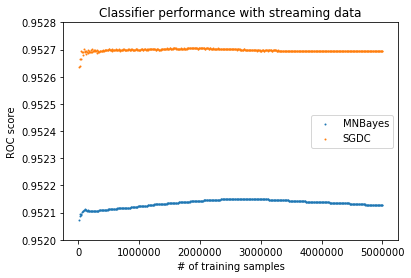

In [116]:
plt.scatter(x = training_samples[:500], y = mnbi_vscore[:500], label = "MNBayes", s = 1)
plt.scatter(x = training_samples[:500], y = sgdc_vcsore[:500], label = "SGDC",s = 1)
plt.xlabel("# of training samples")
plt.ylabel("ROC score")
plt.title("Classifier performance with streaming data")
plt.ylim(ymin = 0.952, ymax = 0.9528)
plt.legend()
plt.show()